In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Health Care 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care
1411,1998-12-02,1171.25,362.970001,-5.686586,-1.767253,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1412,1998-12-03,1150.14,352.160004,-6.036617,-2.991567,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1413,1998-12-04,1176.74,360.369995,-4.892991,-1.742288,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1414,1998-12-07,1187.70,360.679993,-4.157454,-1.305245,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1415,1998-12-08,1181.38,361.799988,-7.134435,-3.422136,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1541.250000,4.852728,0.164424,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7195,2021-11-26,4594.62,1534.349976,1.616263,-1.065848,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7196,2021-11-29,4655.27,1540.150024,1.484354,-1.495335,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7197,2021-11-30,4567.00,1510.449951,1.396956,-1.850005,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561


## Using data after 2010

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care,dow
133,2010,1,2010-01-14,1148.46,376.410004,-2.110431,0.706321,OUTPERFORM,217.281,384.308,311.761,406.672,206.214,3
134,2010,2,2010-02-11,1078.47,358.869995,-11.020997,-0.166914,OUTPERFORM,217.353,385.712,312.658,408.261,206.263,3
135,2010,3,2010-03-11,1150.24,370.440002,5.750719,11.206514,OUTPERFORM,217.403,386.589,313.219,409.253,206.024,3
136,2010,4,2010-04-08,1186.44,370.679993,6.168177,7.997547,OUTPERFORM,217.290,387.094,314.192,409.547,206.180,3
137,2010,5,2010-05-13,1157.44,351.940002,3.805347,5.154023,OUTPERFORM,217.199,388.188,314.995,410.740,206.407,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1496.079956,-2.530346,-3.212076,UNDERPERFORM,273.092,524.845,375.685,572.969,244.968,3
272,2021,8,2021-08-12,4460.83,1547.819946,-1.849766,0.873946,OUTPERFORM,274.214,525.861,376.842,573.939,244.840,3
273,2021,9,2021-09-09,4493.28,1563.829956,-4.490556,0.388369,OUTPERFORM,276.590,528.134,379.003,576.248,246.307,3
274,2021,10,2021-10-14,4438.26,1484.189941,-7.366228,-9.643309,UNDERPERFORM,278.524,529.754,379.483,578.237,246.445,3


In [5]:
original = data[['S&P 500 Health Care (Sector) Outperform/Underperform','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]

In [6]:
data.drop(columns=['date','S&P 500 Health Care (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
133,1,1148.46,376.410004,-2.110431,0.706321,217.281,384.308,311.761,406.672,206.214,3
134,2,1078.47,358.869995,-11.020997,-0.166914,217.353,385.712,312.658,408.261,206.263,3
135,3,1150.24,370.440002,5.750719,11.206514,217.403,386.589,313.219,409.253,206.024,3
136,4,1186.44,370.679993,6.168177,7.997547,217.290,387.094,314.192,409.547,206.180,3
137,5,1157.44,351.940002,3.805347,5.154023,217.199,388.188,314.995,410.740,206.407,3


In [7]:
original['Performance'] = np.where(original['S&P 500 Health Care (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]

In [8]:
dd.data_summary(original)

,Info
Rows,143
Columns,7
Size in Memory,8.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.47,0.50,2,76
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
medical Care,float64,0,0,384.31,454.19,531.27,456.94,43.33,143,1
medical care commodities,float64,0,0,311.76,357.41,387.53,356.34,23.83,143,1
medical care services,float64,0,0,406.67,485.35,580.20,489.052,50.36,143,1
personal Care,float64,0,0,206.024,222.37,247.56,223.40,11.35,142,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

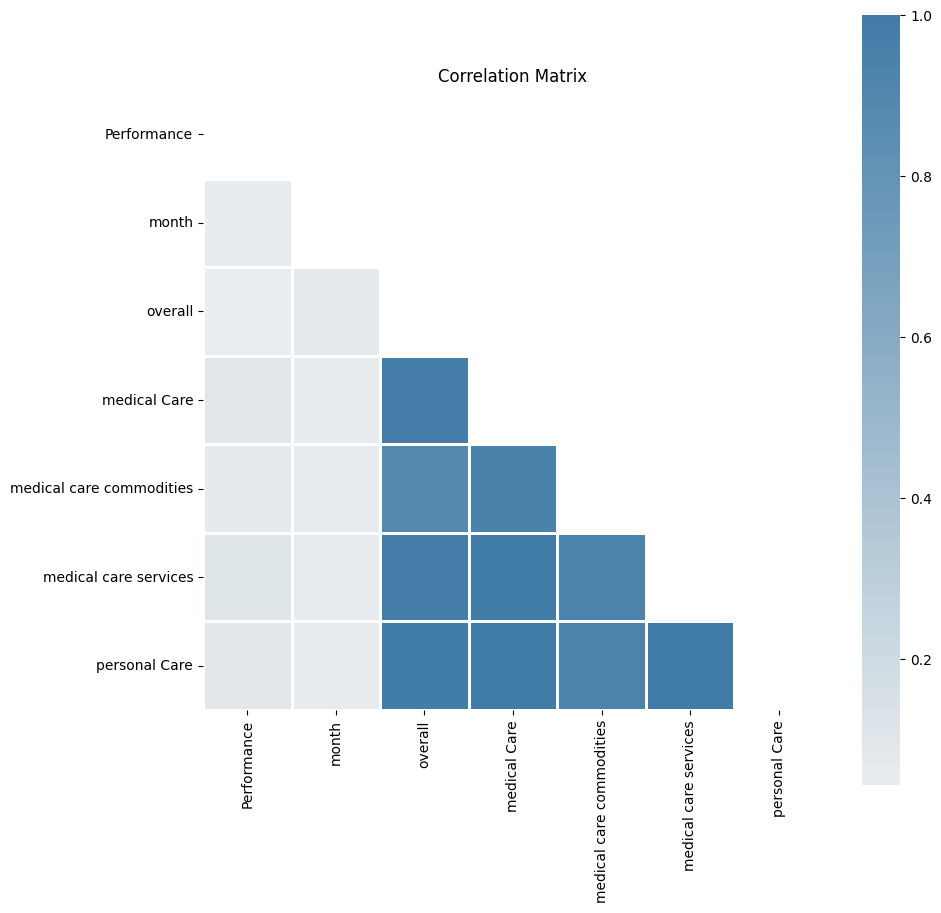

In [9]:
dd.correlation_matrix(original)

### Conditional GAN

In [10]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,7,3553.048603,814.292203,10.436757,3.684919,243.809740,485.013532,348.809741,531.499949,225.532757,3
1,11,1434.904148,393.493725,-2.045873,6.884738,240.415893,422.596903,347.220621,425.809892,211.190374,3
2,8,1153.642178,343.580774,-4.797072,-4.557489,218.318102,408.497125,332.469025,417.597757,205.203432,3
3,12,1355.838059,438.488955,-0.395061,-2.374597,223.344467,396.953706,320.416250,433.835400,203.507471,3
4,12,1325.264039,314.784803,-10.185366,-10.809606,230.659391,439.275691,334.920371,427.229765,210.618508,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,7,1588.066833,401.121730,-4.863019,-3.503716,233.976072,408.335636,334.845534,478.979290,210.800361,3
9996,11,1848.529706,444.646199,-6.881574,-6.400333,232.376861,428.796371,350.312370,499.833234,213.166081,3
9997,3,1673.372667,632.241826,-1.036900,-5.325847,234.908246,417.448710,351.173507,479.217292,212.230806,3
9998,11,2161.874431,1017.669931,-1.398300,-3.151379,242.281178,433.868033,350.974966,557.834531,218.892063,3


In [11]:
samples['Performance'] = np.where(samples['S&P 500 Health Care (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [12]:
samples = samples[['Performance','month', 'overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
samples.head()

,Performance,month,overall,medical Care,medical care commodities,medical care services,personal Care
0,0,7,243.809740,485.013532,348.809741,531.499949,225.532757
1,1,11,240.415893,422.596903,347.220621,425.809892,211.190374
2,1,8,218.318102,408.497125,332.469025,417.597757,205.203432
3,0,12,223.344467,396.953706,320.416250,433.835400,203.507471
4,0,12,230.659391,439.275691,334.920371,427.229765,210.618508


In [13]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.50,0.50,2,5041
month,int64,0,0,1,6,12,6.44,3.43,12,871
overall,float64,0,0,201.61,242.73,289.68,243.65,16.13,10000,1
medical Care,float64,0,0,349.53,457.64,569.33,454.11,45.86,9999,2
medical care commodities,float64,0,0,296.74,356.34,398.29,359.020,22.48,9999,2
medical care services,float64,0,0,363.17,494.78,628.91,496.25,53.70,9999,2
personal Care,float64,0,0,193.69,222.88,258.99,223.75,13.044,9998,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

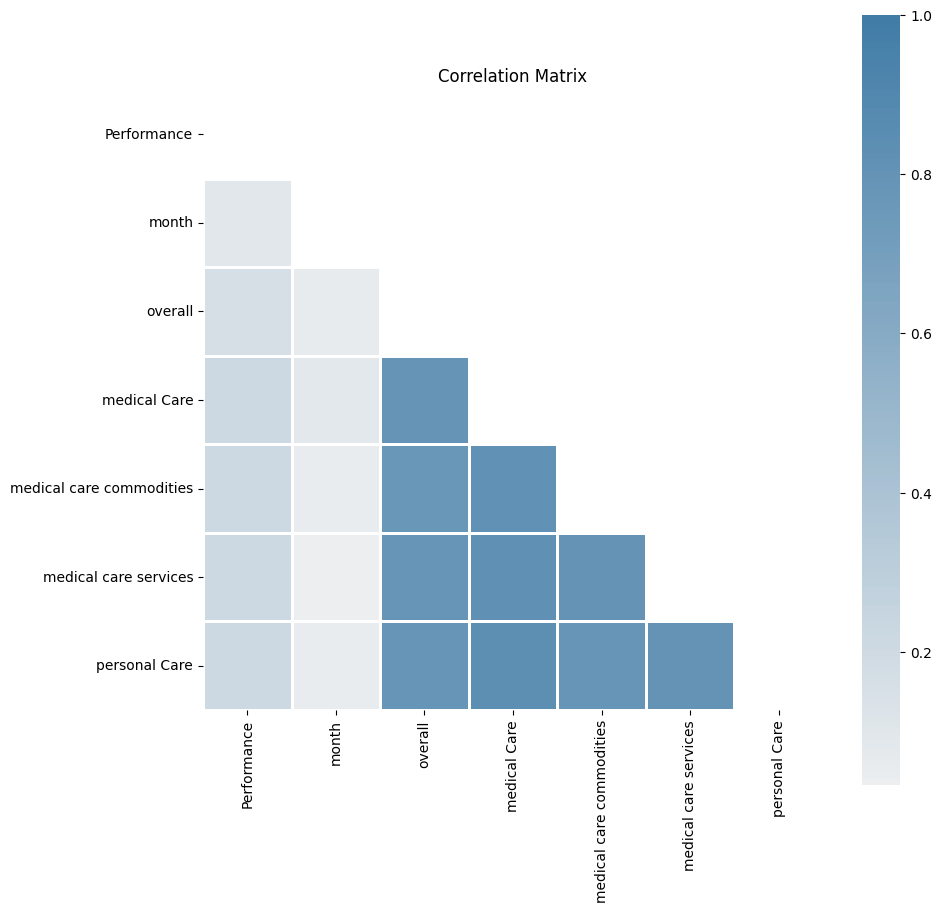

In [14]:
dd.correlation_matrix(samples)

In [15]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [16]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 5041, 1: 4959})
Counter({0: 5041, 1: 5041})


### Interaction Terms

In [17]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[2.43809740e+02, 4.85013532e+02, 3.48809741e+02, ...,
        1.85392360e+05, 7.86680225e+04, 1.19870649e+05],
       [2.40415893e+02, 4.22596903e+02, 3.47220621e+02, ...,
        1.47849975e+05, 7.33296527e+04, 8.99269502e+04],
       [2.18318102e+02, 4.08497125e+02, 3.32469025e+02, ...,
        1.38838319e+05, 6.82237849e+04, 8.56924929e+04],
       ...,
       [2.74451857e+02, 5.36537974e+02, 3.80697826e+02, ...,
        2.18816891e+05, 9.21684149e+04, 1.39156074e+05],
       [2.59675344e+02, 4.79571269e+02, 3.79911079e+02, ...,
        2.05022980e+05, 8.47215258e+04, 1.20346204e+05],
       [2.73373275e+02, 5.39597850e+02, 3.78625901e+02, ...,
        2.20728696e+05, 9.64477677e+04, 1.48501328e+05]])

In [18]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(10082, 16)

In [19]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 16)

In [20]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [21]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.610893,0.611151,0.609403,0.610159,0.625942,0.636,0.619641,0.627714,0.58042,0.547945,0.597015,0.571429
1,DecisionTreeClassifier,0.579648,0.580007,0.57886,0.579275,0.584689,0.592187,0.590803,0.591494,0.566434,0.534247,0.58209,0.557143
2,RandomForestClassifier,0.650668,0.655707,0.634601,0.644712,0.665212,0.683375,0.637568,0.659677,0.678322,0.643836,0.701493,0.671429
3,AdaBoostClassifier,0.660487,0.672187,0.626861,0.648499,0.673542,0.704991,0.616524,0.657796,0.615385,0.596774,0.552239,0.573643
4,GradientBoostingClassifier,0.664454,0.667179,0.656622,0.661709,0.675129,0.696277,0.641465,0.667748,0.643357,0.617647,0.626866,0.622222
5,ExtraTreesClassifier,0.643625,0.647652,0.630437,0.638747,0.659659,0.675475,0.637568,0.655974,0.636364,0.60274,0.656716,0.628571
6,BaggingClassifier,0.627261,0.646174,0.561804,0.600905,0.637445,0.674882,0.554949,0.609068,0.58042,0.566038,0.447761,0.5
7,SVC,0.636088,0.624981,0.681418,0.651788,0.631495,0.642742,0.6212,0.631788,0.587413,0.557143,0.58209,0.569343
8,GaussianNB,0.607522,0.612411,0.586594,0.599124,0.612455,0.628141,0.584567,0.605571,0.594406,0.569231,0.552239,0.560606


## Using all data (Best Model)

In [23]:
data = pd.read_csv('../data/S&P 500 Health Care 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,1998,12,1998-12-10,1165.02,353.089996,-7.051962,-4.950472,OUTPERFORM,164.700,246.500,226.200,251.200,159.000,3
1,1999,1,1999-01-14,1212.19,348.149994,-7.478419,-9.302869,UNDERPERFORM,164.700,247.300,226.900,252.000,159.400,3
2,1999,2,1999-02-11,1254.04,365.540009,-7.793888,-2.699101,OUTPERFORM,164.800,247.900,227.600,252.500,159.900,3
3,1999,3,1999-03-11,1297.68,384.720001,-2.451345,8.992008,OUTPERFORM,165.900,248.700,229.000,253.100,160.000,3
4,1999,4,1999-04-08,1343.98,390.510010,0.084895,15.381887,OUTPERFORM,166.000,249.300,229.200,253.900,160.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1496.079956,-2.530346,-3.212076,UNDERPERFORM,273.092,524.845,375.685,572.969,244.968,3
272,2021,8,2021-08-12,4460.83,1547.819946,-1.849766,0.873946,OUTPERFORM,274.214,525.861,376.842,573.939,244.840,3
273,2021,9,2021-09-09,4493.28,1563.829956,-4.490556,0.388369,OUTPERFORM,276.590,528.134,379.003,576.248,246.307,3
274,2021,10,2021-10-14,4438.26,1484.189941,-7.366228,-9.643309,UNDERPERFORM,278.524,529.754,379.483,578.237,246.445,3


In [24]:
original = data[['S&P 500 Health Care (Sector) Outperform/Underperform','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
data.drop(columns=['date','S&P 500 Health Care (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Health Care (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,10,2140.084560,865.981598,-4.585207,-5.691049,261.203566,454.642012,391.678894,501.328238,246.083644,3
1,9,1135.179725,337.973743,-1.769731,-2.476745,205.654491,341.351729,324.061338,352.801279,210.686987,3
2,10,3196.778375,941.726984,-0.348892,-7.061691,263.821564,540.841553,398.108309,600.897163,247.352879,3
3,9,1599.005910,635.085535,-5.707178,-11.066537,232.295259,411.496379,362.036770,485.659610,215.215211,3
4,1,1939.129846,472.051395,-4.290397,-14.088918,232.738619,462.137729,355.263255,524.246425,218.569686,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,9,1834.224277,860.777371,-5.911079,-3.309390,239.170514,436.209307,389.246380,499.283137,227.182959,3
9996,8,3056.055519,338.169858,-2.682459,-9.010207,246.748273,409.491557,368.419744,442.986760,216.999493,3
9997,11,3121.980359,1057.109794,-0.700350,0.937127,245.748754,500.446450,379.381409,484.266861,223.773970,3
9998,3,1555.326924,532.443323,-0.236972,-2.653286,228.904949,413.585673,376.337324,405.578657,226.684790,3


In [25]:
samples['Performance'] = np.where(samples['S&P 500 Health Care (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.678972,0.652851,0.758767,0.701025,0.669188,0.647844,0.736719,0.689429,0.536232,0.529915,0.459259,0.492063
1,DecisionTreeClassifier,0.672422,0.660481,0.705519,0.68124,0.665697,0.659322,0.681261,0.670112,0.521739,0.513043,0.437037,0.472
2,RandomForestClassifier,0.768675,0.746912,0.807225,0.773503,0.748618,0.731841,0.782253,0.756208,0.554348,0.630435,0.214815,0.320442
3,AdaBoostClassifier,0.614727,0.594476,0.720208,0.651059,0.618272,0.597567,0.716871,0.651805,0.565217,0.56,0.518519,0.538462
4,GradientBoostingClassifier,0.634735,0.61492,0.718897,0.662701,0.636311,0.615002,0.722709,0.66452,0.557971,0.555556,0.481481,0.515873
5,ExtraTreesClassifier,0.796828,0.778146,0.826576,0.799234,0.773931,0.768041,0.782837,0.775369,0.536232,0.566038,0.222222,0.319149
6,BaggingClassifier,0.725752,0.728153,0.714979,0.718964,0.70934,0.723125,0.675423,0.698461,0.532609,0.557692,0.214815,0.31016
7,SVC,0.614364,0.596659,0.704058,0.645717,0.627291,0.608325,0.708114,0.654438,0.583333,0.574627,0.57037,0.572491
8,GaussianNB,0.591954,0.574943,0.705074,0.633368,0.594996,0.576978,0.702277,0.633491,0.543478,0.528662,0.614815,0.568493


### Voting Classifier

In [26]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.759092,0.7422,0.791594,0.766102
